# Import bibliotek

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie danych

In [9]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              20000 non-null  int64  
 1   Income           20000 non-null  float64
 2   CreditScore      17617 non-null  float64
 3   LoanAmount       20000 non-null  float64
 4   EmploymentYears  20000 non-null  int64  
 5   NumDependents    20000 non-null  int64  
 6   DebtToIncome     20000 non-null  float64
 7   EducationLevel   20000 non-null  int64  
 8   FavoriteColor    20000 non-null  object 
 9   Hobby            20000 non-null  object 
 10  Default          20000 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 1.7+ MB


# Eksploracja danych
W poniższej sekcji przeanalizowano zbiór treningowy danych. W pierwszej kolejności ze zbioru wykluczono dane niemające uzasadnienia biznesowego (FavoriteColor oraz Hobby).

In [4]:
train_df = train_df.drop(columns=['FavoriteColor', 'Hobby'])
null_counts = train_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
Age                   0
Income                0
CreditScore        2383
LoanAmount            0
EmploymentYears       0
NumDependents         0
DebtToIncome          0
EducationLevel        0
Default               0
dtype: int64


In [5]:
train_df.describe()

,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome,EducationLevel,Default
count,20000.000000,20000.000000,17617.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000
mean,44.959150,50004.431236,574.118635,20030.527761,19.369250,1.98985,0.502592,2.506150,0.343150
std,14.083764,15019.289666,159.041321,4992.059462,11.548159,1.41193,0.289153,1.116882,0.474773
min,21.000000,-16984.057953,300.000000,-2314.842635,0.000000,0.00000,0.000018,1.000000,0.000000
25%,33.000000,39716.883271,437.000000,16646.478319,9.000000,1.00000,0.251572,2.000000,0.000000
50%,45.000000,50084.103696,575.000000,20046.233086,19.000000,2.00000,0.501503,3.000000,0.000000
75%,57.000000,60285.318369,711.000000,23393.056940,29.000000,3.00000,0.753517,4.000000,1.000000
max,69.000000,117186.263765,849.000000,38800.776243,39.000000,4.00000,0.999984,4.000000,1.000000


W zbiorze treningowym braki wsytępują w kolumnie 'CreditScore' - 2383 wartości null. Jako że jest to jedna z najistotniejszych zmiennych w predykcji niewypłacalności, usunięcie wierszy z brakami (stanowiących ponad 10% danych treningowych) byłoby nieoptymalne. 

## Analiza danych numerycznych
Po usunięciu zmiennych nieistotnych z punktu widzenia bzinesowego, zbiór danych zawiera wyłącznie dane numeryczne.

In [12]:
num_cols = train_df.select_dtypes(exclude=['object']).columns
num_cols

Index(['Age', 'Income', 'CreditScore', 'LoanAmount', 'EmploymentYears',
       'NumDependents', 'DebtToIncome', 'EducationLevel', 'Default'],
      dtype='object')

### Analiza wartości odstających
yap yap yap o tym że boxploty i zscore

#### Analiza wykresów pudełkowych

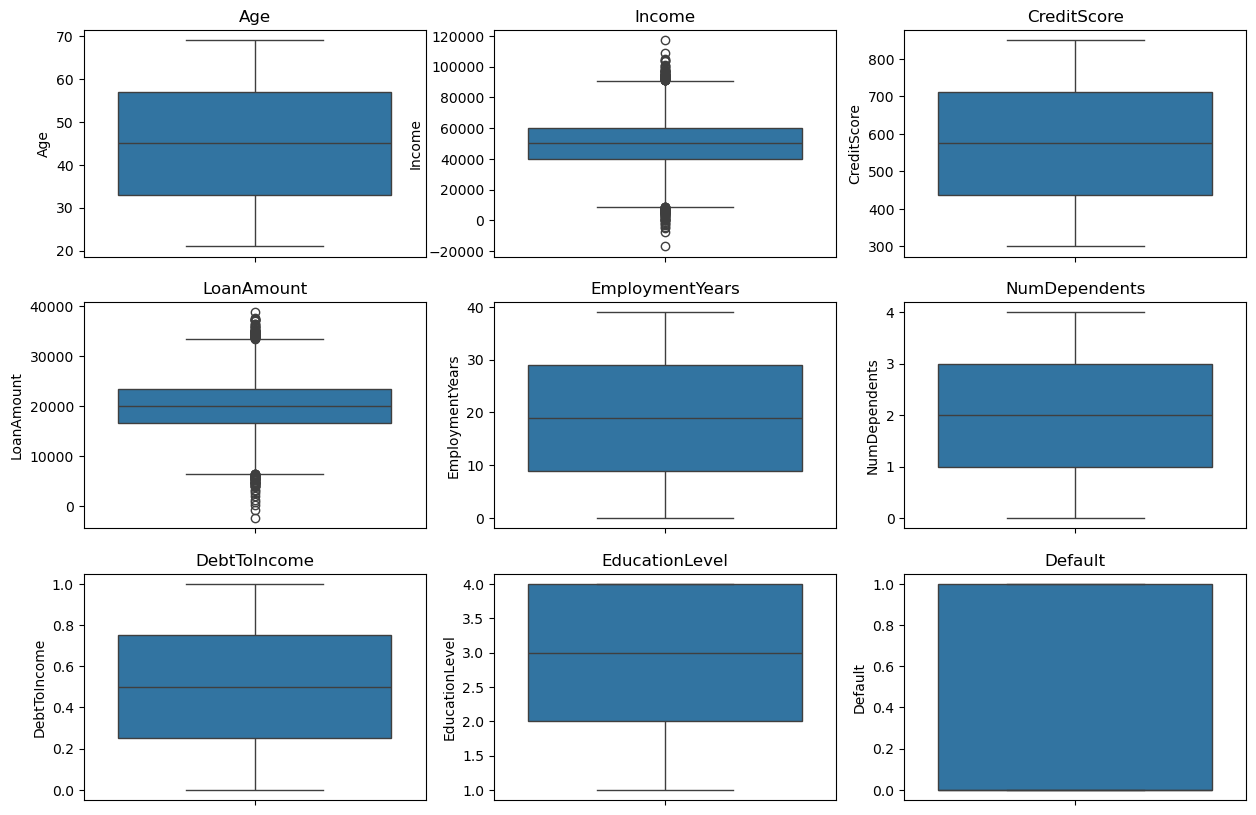

In [15]:
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title(col)
    sns.boxplot(data=train_df[col], ax=ax)
plt.show()

#### Analiza Z-Score

In [17]:
#Przygotowanie tabeli
indeks = []
ilosc = []
minimum = []
maksimum = []
srednia = []
kwartyl_1 = []
mediana = []
kwartyl_3 = []
outliery = []
outliery_procent = []
outliery_zscore = []
outliery_procent_zscore = []

#Pętla przez kolumny numeryczne
for col in num_cols:
    indeks.append(col)
    ilosc.append(train_df[col].count())
    minimum.append(train_df[col].min())
    maksimum.append(train_df[col].max())
    srednia.append(train_df[col].mean())
    kwartyl_1.append(train_df[col].quantile(0.25))
    mediana.append(train_df[col].median())
    kwartyl_3.append(train_df[col].quantile(0.75))
    
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)][col].count()
    outliery.append(outlier_count)
    outliery_procent.append((outlier_count / train_df[col].count()) * 100)
    
    z_scores = (train_df[col] - train_df[col].mean()) / train_df[col].std()
    z_outlier_count = train_df[(z_scores < -3) | (z_scores > 3)][col].count()
    outliery_zscore.append(z_outlier_count)
    outliery_procent_zscore.append((z_outlier_count / train_df[col].count()) * 100)

tabela_statystyczna = pd.DataFrame({
    'Indeks': indeks,
    'Ilość': ilosc,
    'Minimum': minimum,
    'Maksimum': maksimum,
    'Średnia': srednia,
    'Kwartyl 1': kwartyl_1,
    'Mediana': mediana,
    'Kwartyl 3': kwartyl_3,
    'Liczba outlierów (IQR)': outliery,
    'Procent outlierów (IQR)': outliery_procent,
    'Liczba outlierów (Z-score)': outliery_zscore,
    'Procent outlierów (Z-score)': outliery_procent_zscore
})
tabela_statystyczna

,Indeks,Ilość,Minimum,Maksimum,Średnia,Kwartyl 1,Mediana,Kwartyl 3,Liczba outlierów (IQR),Procent outlierów (IQR),Liczba outlierów (Z-score),Procent outlierów (Z-score)
0,Age,20000,21.000000,69.000000,44.959150,33.000000,45.000000,57.000000,0,0.000,0,0.00
1,Income,20000,-16984.057953,117186.263765,50004.431236,39716.883271,50084.103696,60285.318369,129,0.645,54,0.27
2,CreditScore,17617,300.000000,849.000000,574.118635,437.000000,575.000000,711.000000,0,0.000,0,0.00
3,LoanAmount,20000,-2314.842635,38800.776243,20030.527761,16646.478319,20046.233086,23393.056940,135,0.675,50,0.25
4,EmploymentYears,20000,0.000000,39.000000,19.369250,9.000000,19.000000,29.000000,0,0.000,0,0.00
5,NumDependents,20000,0.000000,4.000000,1.989850,1.000000,2.000000,3.000000,0,0.000,0,0.00
6,DebtToIncome,20000,0.000018,0.999984,0.502592,0.251572,0.501503,0.753517,0,0.000,0,0.00
7,EducationLevel,20000,1.000000,4.000000,2.506150,2.000000,3.000000,4.000000,0,0.000,0,0.00
8,Default,20000,0.000000,1.000000,0.343150,0.000000,0.000000,1.000000,0,0.000,0,0.00


### Braki danych
W niniejszej sekcji podjęto próbę zadresowania problemu braku danych w kolumnie <i>CreditScore</i>

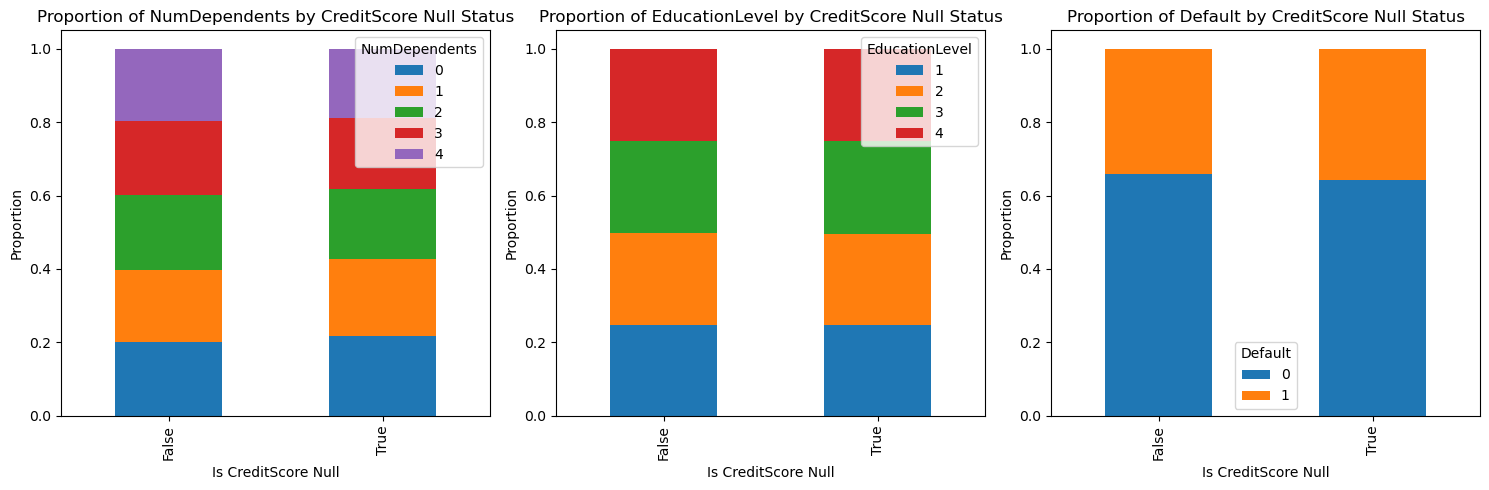

In [43]:
vars = ['NumDependents', 'EducationLevel', 'Default']
fig = plt.figure(figsize=(15, 5))

for i, var in enumerate(vars):
    ax = fig.add_subplot(1, 3, i + 1)
    null_analysis = train_df.groupby(train_df['CreditScore'].isnull())[var].value_counts(normalize=True).unstack()
    null_analysis.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(f'Proportion of {var} by CreditScore Null Status')
    ax.set_xlabel('Is CreditScore Null')
    ax.set_ylabel('Proportion')

plt.tight_layout()
plt.show()


Analiza zależności braków danych w kolumnie CreditScore od zmiennych NumDependents, EducationLevel i zmiennej celu Default nie wykazała istotnych różnic w proporcjach. Rozkład poszczególnych kategorii w tych zmiennych był niemal identyczny zarówno dla klientów z brakującym, jak i z obecnym CreditScore. Wskazuje to, że braki te nie są silnie determinowane przez te czynniki.

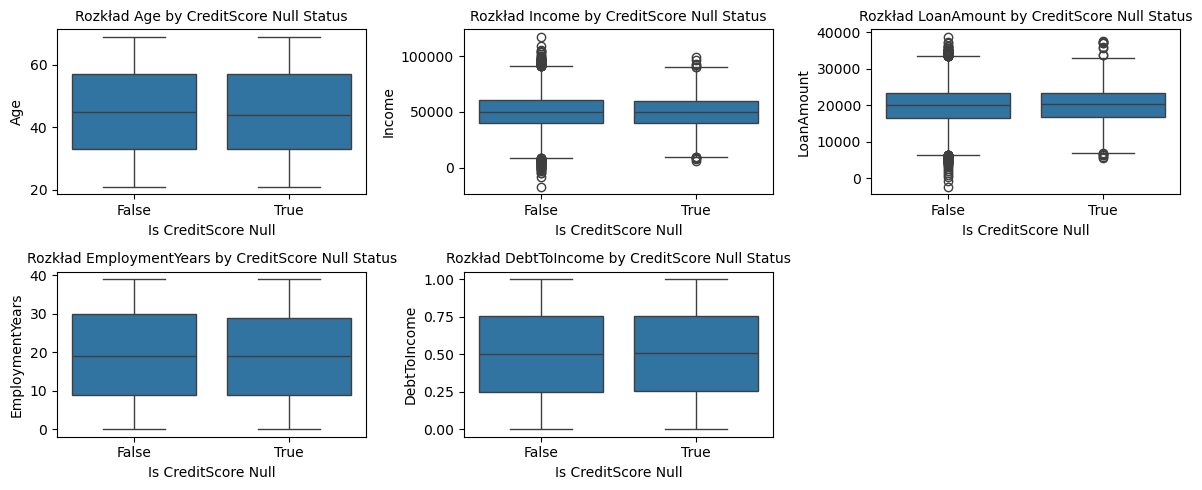

In [57]:
vars2 = ['Age', 'Income', 'LoanAmount', 'EmploymentYears', 'DebtToIncome']
fig = plt.figure(figsize=(12, 5))

for i, var in enumerate(vars2):
    ax = fig.add_subplot(2, 3, i + 1)
    sns.boxplot(
        x=train_df['CreditScore'].isnull(),
        y=train_df[var],
        ax=ax
    )
    ax.set_title(f'Rozkład {var} by CreditScore Null Status', fontsize=10)
    ax.set_xlabel('Is CreditScore Null')
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()